# Watermass transformation in the CDW density range



Watermass transformation rates are defined as:

\begin{eqnarray}
    \Omega &=& \frac{\partial}{\partial \sigma} \int \int \int \frac{D \sigma'}{D t} dV, \\
    \Omega(\sigma, t)_{i,j} &=& A_c \frac{1}{\Delta \sigma} \sum^{N_z} \bigg (  \frac{D \sigma}{D t}  h_c \Delta z_f \delta(\sigma - \sigma') \bigg ),
\end{eqnarray}

$$ \frac{D \sigma}{Dt} = \frac{\partial \sigma}{\partial \theta} \dot{\theta} + \frac{\partial \sigma}{\partial S}\dot{S} $$

$ \alpha = -\frac{1}{\rho} \frac{\partial \sigma}{\partial \theta}$ and $\beta = \frac{1}{\rho} \frac{\partial \sigma}{\partial S_A}$

$$\dot{\theta} = \frac{D \theta}{Dt} = \frac{\partial \theta}{\partial t} + u\frac{\partial \theta}{\partial x} + v\frac{\partial \theta}{\partial y}  = G^\theta_{hdiff} + G^\theta_{vdiff} + G^\theta_{surf} + G^\theta_{SW}$$

$$\dot{S} = \frac{D S}{Dt} = \frac{\partial S}{\partial t} + u\frac{\partial S}{\partial x} + v\frac{\partial S}{\partial y} = G^S_{hdiff} + G^S_{vdiff} + G^S_{surf}$$


Since we have the theta and salinity advective terms available as online outputs at monthly frequency, we can use that to directly obtain the 

$$\dot{\theta} = \frac{\delta \theta}{\Delta t} + \frac{\delta (u\theta \Delta z \Delta y)}{\Delta x \Delta y \Delta z} + \frac{\delta (v\theta \Delta z \Delta x)}{\Delta x \Delta y \Delta z}$$ 

Where $\delta$ is the difference operator.



## Setup variables and the model grid

In [1]:
%config Completer.use_jedi = False

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import cmocean as cm
import xarray as xr
import numpy as np
import IPython.display
import cosima_cookbook as cc
import pandas as pd
import gsw

In [3]:
session = cc.database.create_session()

In [4]:
expList = cc.querying.get_experiments(session)

In [5]:
expList.loc[expList["experiment"].str.contains("01deg_jra55v140_iaf_cycle4")]

experiment  ncfiles
94                       01deg_jra55v140_iaf_cycle4   131990
156  01deg_jra55v140_iaf_cycle4_jra55v150_extension    13422
184      01deg_jra55v140_iaf_cycle4_rerun_from_1983      172
185      01deg_jra55v140_iaf_cycle4_rerun_from_1986       86
188      01deg_jra55v140_iaf_cycle4_rerun_from_1980     2582

In [4]:
experiment = "01deg_jra55v140_iaf_cycle4" # Selecting the experiment with the interannualy forced run, cycle-4

In [101]:
fileList = cc.querying.get_ncfiles(session, experiment)

In [36]:
varList = cc.querying.get_variables(session, experiment=experiment, frequency="1 monthly")

In [91]:
varList["frequency"].unique()

array([None, '1 daily', '1 monthly', 'static'], dtype=object)

In [65]:
varList.loc[varList["name"].str.lower().str.contains("dz")]#.loc[163, "ncfile"]

name                                          long_name  \
43              dzt                                   t-cell thickness   
131  temp_int_rhodz  vertical sum of Conservative temperature * rho...   

                units  frequency  \
43                  m  1 monthly   
131  deg_C*(kg/m^3)*m  1 monthly   

                                                ncfile cell_methods  \
43   output991/ocean/ocean-3d-dzt-1-monthly-mean-ym...   time: mean   
131  output991/ocean/ocean-2d-temp_int_rhodz-1-mont...   time: mean   

     # ncfiles           time_start             time_end  
43         732  1958-01-01 00:00:00  2019-01-01 00:00:00  
131        732  1958-01-01 00:00:00  2019-01-01 00:00:00

In [5]:
dxt = cc.querying.getvar(experiment, "dxt", session, n=1)

dxt = dxt.sel(yt_ocean = slice(-90, -60))

dxu = cc.querying.getvar(experiment, "dxu", session, n=1)

dxu = dxu.sel(yu_ocean = slice(-90, -60))

dyt = cc.querying.getvar(experiment, "dyt", session, n=1)

dyt = dyt.sel(yt_ocean = slice(-90, -60))

dyu = cc.querying.getvar(experiment, "dyu", session, n=1)

dyu = dyu.sel(yu_ocean = slice(-90, -60))

In [6]:
dzt = cc.querying.getvar(experiment, "dzt", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
# This is the time-varying depth cell thickness on the z* coordinate system

dzt = dzt.sel(yt_ocean = slice(-90, -60))

dzt0 = dzt.isel(time = 0).load()

sw_ocean = cc.querying.getvar(experiment, "sw_ocean", session, frequency="1 monthly")
# This is the vertical coordinate on the w level

pot_rho_0 = cc.querying.getvar(experiment, "pot_rho_0", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
# The potential density referenced to 0dbar surface

pot_rho_0 = pot_rho_0.sel(yt_ocean = slice(-90, -60))

temp = cc.querying.getvar(experiment, "temp", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")

temp = temp.sel(yt_ocean = slice(-90, -60))

temp_xflux_adv = cc.querying.getvar(experiment, "temp_xflux_adv", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
# This is Cp*rho*dzt*dyt*u*theta
temp_xflux_adv = temp_xflux_adv.sel(yt_ocean = slice(-90, -60))

temp_yflux_adv = cc.querying.getvar(experiment, "temp_yflux_adv", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
# This is Cp*rho*dzt*dxt*v*theta
temp_yflux_adv = temp_yflux_adv.sel(yu_ocean = slice(-90, -60))

salt = cc.querying.getvar(experiment, "salt", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
salt = salt.sel(yt_ocean = slice(-90, -60))

salt_xflux_adv = cc.querying.getvar(experiment, "salt_xflux_adv", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
# This is dzt*dyt*u*S
salt_xflux_adv = salt_xflux_adv.sel(yt_ocean = slice(-90, -60))

salt_yflux_adv = cc.querying.getvar(experiment, "salt_yflux_adv", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
# This is dzt*dxt*v*S
salt_yflux_adv = salt_yflux_adv.sel(yu_ocean = slice(-90, -60))

In [7]:
u = cc.querying.getvar(experiment, "u", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
u = u.sel(yu_ocean = slice(-90, -60))
v = cc.querying.getvar(experiment, "v", session, start_time="1990-01-01", end_time="2019-01-01", frequency="1 monthly")
v = v.sel(yu_ocean = slice(-90, -60))

In [8]:
ds = xr.Dataset(coords = {"yt_ocean":(["yt_ocean"], temp.yt_ocean.values, {'axis': 'Y', 'c_grid_axis_shift': None}),
                          "yu_ocean":(["yu_ocean"], temp_yflux_adv.yu_ocean.values, {'axis': 'Y', 'c_grid_axis_shift': -0.5}),
                          "xt_ocean":(["xt_ocean"], temp.xt_ocean.values, {"axis":"X", "c_grid_axis_shift":None}),
                          "xu_ocean":(["xu_ocean"], temp_xflux_adv.xu_ocean.values, {"axis":"X", "c_grid_axis_shift": -0.5}),
                          "dxt":(["yt_ocean", "xt_ocean"], dxt.data),
                          "dxu":(["yu_ocean", "xu_ocean"], dxu.data),
                          "dyt":(["yt_ocean", "xt_ocean"], dyt.data),
                          "dyu":(["yu_ocean", "xu_ocean"], dxu.data)
                         })
# create a dataset with the coordinate system of the model

In [9]:
delta_lat_t2t = np.diff(ds["yt_ocean"])
delta_lat_t2t = np.append(delta_lat_t2t, delta_lat_t2t[-1])
# compute the T-point to T-point width of grid cells in the Y direction

delta_lat_u2u = np.diff(ds["yu_ocean"].values)
delta_lat_u2u = np.append(delta_lat_u2u, delta_lat_u2u[-1])
# compute the U-point to U-point width of grid cells in the Y direction

In [10]:
Re = 6370e3 # Radius of the earth in meters

In [11]:
delta_y_t2t = np.abs(Re * np.deg2rad(delta_lat_t2t)) # delta(lat) converted to distance in meters 
delta_y_u2u = np.abs(Re * np.deg2rad(delta_lat_u2u)) # delta(lat) converted to distance in meters 

In [12]:
delta_lon_t2t = np.diff(ds["xt_ocean"]) # delta lon in meters from T-point to T-point
delta_lon_t2t = np.append(delta_lon_t2t, delta_lon_t2t[-1])

In [13]:
delta_lon_u2u = np.diff(ds["xu_ocean"]) # delta lon in meters from U-point to U-point
delta_lon_u2u = np.append(delta_lon_u2u, delta_lon_u2u[-1])

In [14]:
delta_x_t2t = np.zeros((ds["yt_ocean"].shape[-1], ds["xu_ocean"].shape[-1])) 
for i in range(len(ds["yt_ocean"].values)):
    delta_x_t2t[i] = np.abs(Re * np.cos( np.deg2rad(ds["yt_ocean"].values[i]) ) * np.deg2rad(delta_lon_t2t)) # Compute the grid cell width in meters along the X direction from T-point to T-point

In [15]:
delta_x_u2u = np.zeros((ds["yt_ocean"].shape[-1], ds["xt_ocean"].shape[-1]))
for i in range(len(ds["yt_ocean"].values)):
    delta_x_u2u[i] = np.abs(Re * np.cos( np.deg2rad(ds["yt_ocean"].values[i]) ) * np.deg2rad(delta_lon_u2u)) # Compute the grid cell width in meters along the X direction from U-point to U-point

In [16]:
st_ocean = temp.st_ocean
delta_s_t2t = np.diff(st_ocean) # grid cell thickness in the Z direction
delta_s_t2t = np.append(delta_s_t2t, delta_s_t2t[-1])

In [17]:
delta_s_w2w = np.diff(sw_ocean) # grid cell thickness in the Z direction
delta_s_w2w = np.append(delta_s_w2w, delta_s_w2w[-1])

In [18]:
time_vars = temp.time

In [19]:
ds = xr.Dataset(coords = {"yt_ocean":(["yt_ocean"], temp.yt_ocean.values, {'axis': 'Y', 'c_grid_axis_shift': None}),
                          "yu_ocean":(["yu_ocean"], temp_yflux_adv.yu_ocean.values, {'axis': 'Y', 'c_grid_axis_shift': -0.5}),
                          "xt_ocean":(["xt_ocean"], temp.xt_ocean.values, {"axis":"X", "c_grid_axis_shift":None}),
                          "xu_ocean":(["xu_ocean"], temp_xflux_adv.xu_ocean.values, {"axis":"X", "c_grid_axis_shift": -0.5}),
                          "st_ocean":(["st_ocean"], temp.st_ocean.values, {"axis":"Z", "c_grid_axis_shift": None}),
                          "sw_ocean":(["sw_ocean"], sw_ocean.values, {"axis":"Z", "c_grid_axis_shift": -0.5}),


                          "dxt":(["yt_ocean", "xt_ocean"], dxt.data),
                          "dxu":(["yu_ocean", "xu_ocean"], dxu.data),
                          "dyt":(["yt_ocean", "xt_ocean"], dyt.data),
                          "dyu":(["yu_ocean", "xu_ocean"], dxu.data),
                          "delta_s_t2t":(["sw_ocean"], delta_s_t2t, {"axis":"Z", "c_grid_axis_shift":-0.5}),
                          "delta_s_w2w":(["st_ocean"], delta_s_w2w, {"axis":"Z", "c_grid_axis_shift":None}),
                          "delta_y_t2t":(["yu_ocean"], delta_y_t2t, {'axis': 'Y', 'c_grid_axis_shift': -0.5}),
                          "delta_y_u2u":(["yt_ocean"], delta_y_u2u, {'axis': 'Y', 'c_grid_axis_shift': None}),
                          "delta_x_t2t":(["yt_ocean", "xu_ocean"], delta_x_t2t),
                          "delta_x_u2u":(["yt_ocean", "xt_ocean"], delta_x_u2u),
                         })
# create a dataset with all the relevant coordinates and grid cell metrics

In [20]:
from xgcm import Grid 
# xgcm allows grid-aware computation if given all the grid metrics (cell sizes)

In [21]:
xgrid = Grid(ds, 
            metrics={("X",):["dxt", "dxu"],
                     ("Y",):["dyt", "dyu"],
                     ("Z"):["delta_s_t2t", "delta_s_w2w"]
            })
# create an xgcm grid which can carry out differencing and interpolation operations with awareness of the grid metrics

In [22]:
years_to_step_by = np.arange(2012, 2019, 1) # years over which to compute WMT

In [23]:
years_to_step_by

array([2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [24]:
tarea = ds["dxt"] * ds["dyt"] # Area of a T cell

In [25]:
sigma_intervals = np.linspace(27.67, 27.9, 20) # the potential density intervals over which WMT will be computed
sigma_delta = sigma_intervals[1] - sigma_intervals[0] # delta(sigma)


In [26]:
# rechunk all Dask arrays into chunksize of 12 along time axis. This will be more efficient when computing WMT year-by-year.
temp = temp.sel(time = slice("1990", "2019")).chunk({"time":12})
salt = salt.sel(time = slice("1990", "2019")).chunk({"time":12})
temp_xflux_adv = temp_xflux_adv.sel(time = slice("1990", "2019")).chunk({"time":12})
temp_yflux_adv = temp_yflux_adv.sel(time = slice("1990", "2019")).chunk({"time":12})
salt_xflux_adv = salt_xflux_adv.sel(time = slice("1990", "2019")).chunk({"time":12})
salt_yflux_adv = salt_yflux_adv.sel(time = slice("1990", "2019")).chunk({"time":12})
pot_rho_0 = pot_rho_0.sel(time = slice("1990", "2019")).chunk({"time":12})


dzt = dzt.sel(time = slice("1990", "2019")).chunk({"time":12})

In [27]:
volume_cell_t = ds["dxt"] * ds["dyt"] * dzt # volume of a T cell

In [28]:
import time

## Compute WMT

In [42]:
for y in np.arange(1990, 1991, 1):#years_to_step_by:
    print(y)
    start = time.time()
    # create an Omega for each year (~2.5GB). Omega is the WMT
    # We will compute WMT for the temperature and salinity component and store both components. This will be ~6GB per year.
    Omega = np.full_like(np.zeros((2, len(sigma_intervals)-1, 12, len(temp.yt_ocean.values), len(temp.xt_ocean.values) )), fill_value=0.)

    DeltaVolume = volume_cell_t.sel(time = str(y))
    Cp, rho0 = 4e3, 1035.0

    Dtemp_Dt = temp.sel(time=str(y)).differentiate("time", datetime_unit="s") + xgrid.diff(temp_xflux_adv.sel(time=str(y)), "X") / (DeltaVolume*Cp*rho0) + \
               xgrid.diff(temp_yflux_adv.sel(time=str(y)), "Y") / (DeltaVolume*Cp*rho0)
    # compute the material derivative of temperature. Okay to leave it in Kelvin here as we are computing derivatives.

    Dsalt_Dt = salt.sel(time=str(y)).differentiate("time", datetime_unit="s") + xgrid.diff(salt_xflux_adv.sel(time=str(y)), "X") / (rho0 * DeltaVolume) + \
               xgrid.diff(salt_yflux_adv.sel(time=str(y)), "Y") / (rho0 * DeltaVolume)
    # compute the material derivative of salt
    
    DsaltAbs_Dt = gsw.SA_from_SP(Dsalt_Dt, st_ocean, Dsalt_Dt.xt_ocean, Dsalt_Dt.yt_ocean) # convert DS/Dt to absolute salinity

    absSalt = gsw.SA_from_SP(salt.sel(time=str(y)), st_ocean, salt.xt_ocean, salt.yt_ocean) # convert salinity to absolute salinity

    #alpha = gsw.alpha(absSalt, temp.sel(time=str(y))-273.15, st_ocean) # compute the coefficient of thermal expansion
    alpha = gsw.alpha(salt.sel(time=str(y)), temp.sel(time=str(y))-273.15, st_ocean) # compute the coefficient of thermal expansion

    #beta = gsw.beta(absSalt, temp-273.15, st_ocean) # compute the coefficient of haline contraction
    beta = gsw.beta(salt.sel(time=str(y)), temp.sel(time=str(y))-273.15, st_ocean) # compute the coefficient of haline contraction

    Dsigma_Dt_temp = -rho0 * alpha * Dtemp_Dt # compute the material derivative of sigma due to temperature

    #Dsigma_Dt_salt = rho0 * beta * DsaltAbs_Dt # compute the material derivative of sigma due to salinity
    Dsigma_Dt_salt = rho0 * beta * Dsalt_Dt # compute the material derivative of sigma due to salinity

    Dsigma_Dt = Dsigma_Dt_temp + Dsigma_Dt_salt # add up to get the total
    
    sigma_seld = pot_rho_0.sel(time = str(y)).sel(st_ocean=slice(0,1000)) # select the upper 1,000m ocean
    
    for si in range(len(sigma_intervals)-1): # loop over each sigma interval
        # pot_rho_0 is the absolute density. Add 1000 to sigma_intervals to match the same.
        Omega[0, si] =  (tarea * (Dsigma_Dt_temp.sel(st_ocean=slice(0,1000)).\
                           where((sigma_seld < (sigma_intervals[si] + sigma_delta*0.5 + 1e3)) & 
                               (sigma_seld > (sigma_intervals[si] - sigma_delta*0.5 + 1e3)) ) * 
                                                dzt.sel(time=str(y)).sel(st_ocean=slice(0,1000))).sum("st_ocean") /\
                                  sigma_delta).fillna(0.0).transpose("time", "yt_ocean", "xt_ocean") 
        #fillna to avoid propagating NaNs; 0 to 700m because potential density approximates a neutral surface within ~500m of it's reference surface. Also, we are looking at near-surface processes here.

        Omega[1, si] =  (tarea * (Dsigma_Dt_salt.sel(st_ocean=slice(0,1000)).\
                           where((sigma_seld < (sigma_intervals[si] + sigma_delta*0.5 + 1e3)) & 
                               (sigma_seld > (sigma_intervals[si] - sigma_delta*0.5 + 1e3)) ) * 
                                                dzt.sel(time=str(y)).sel(st_ocean=slice(0,1000))).sum("st_ocean") /\
                                  sigma_delta).fillna(0.0).transpose("time", "yt_ocean", "xt_ocean") 
        #fillna to avoid propagating NaNs; 0 to 700m because potential density approximates a neutral surface within ~500m of it's reference surface. Also, we are looking at near-surface processes here.

    # create an xarray dataset with WMT for the year
    Omega = xr.Dataset({"Omega_temperature":(["sigma", "time", "yt_ocean", "xt_ocean"], Omega[0]),
                    "Omega_salinity": (["sigma", "time", "yt_ocean", "xt_ocean"],Omega[1])}, 
                    coords = {"sigma":(["sigma"], sigma_intervals[:-1]),
                              "time":(["time"], Dsigma_Dt.time.values),
                              "yt_ocean":(["yt_ocean"], Dsigma_Dt.yt_ocean.values),
                              "xt_ocean":(["xt_ocean"], Dsigma_Dt.xt_ocean.values)})

    # output WMT computed for each year to disk
    Omega.to_netcdf("/scratch/g40/an1995/WMT/"+str(y)+".nc")

1990


KeyboardInterrupt: 

\begin{eqnarray}
    \Omega &=& \frac{\partial}{\partial \sigma} \int \int \int \frac{D \sigma'}{D t} dV, \\
    \Omega(\sigma, t)_{i,j} &=& A_c \frac{1}{\Delta \sigma} \sum^{N_z} \bigg (  \frac{D \sigma}{D t}  h_c \Delta z_f \delta(\sigma - \sigma') \bigg ),
\end{eqnarray}

In [37]:
ds = xr.Dataset({"temp":(["time", "st_ocean", "yt_ocean", "xt_ocean"], temp.data),
                 "salt":(["time", "st_ocean", "yt_ocean", "xt_ocean"], salt.data),
                 "u":(["time", "st_ocean", "yu_ocean", "xu_ocean"], u.sel(time=slice("1990-01-01", "2018-12-31")).data),
                 "v":(["time", "st_ocean", "yu_ocean", "xu_ocean"], v.sel(time=slice("1990-01-01", "2018-12-31")).data),
                 "pot_rho_0":(["time", "st_ocean", "yt_ocean", "xt_ocean"], pot_rho_0.data),
                 "volume_cell_t":(["time", "st_ocean", "yt_ocean", "xt_ocean"], volume_cell_t.transpose("time", "st_ocean", "yt_ocean", "xt_ocean").data),
                 "temp_xflux_adv":(["time", "st_ocean", "yt_ocean", "xu_ocean"], temp_xflux_adv.data),
                 "temp_yflux_adv":(["time", "st_ocean", "yu_ocean", "xt_ocean"], temp_yflux_adv.data),
                 "salt_xflux_adv":(["time", "st_ocean", "yt_ocean", "xu_ocean"], salt_xflux_adv.data),
                 "salt_yflux_adv":(["time", "st_ocean", "yu_ocean", "xt_ocean"], salt_yflux_adv.data),
                 "dzt":(["time", "st_ocean", "yt_ocean", "xt_ocean"], dzt.data),},
    
    
    coords = {"time":(["time"], temp.time.values, {"axis":"time"}),
                        "yt_ocean":(["yt_ocean"], temp.yt_ocean.values, {'axis': 'Y', 'c_grid_axis_shift': None}),
                          "yu_ocean":(["yu_ocean"], temp_yflux_adv.yu_ocean.values, {'axis': 'Y', 'c_grid_axis_shift': -0.5}),
                          "xt_ocean":(["xt_ocean"], temp.xt_ocean.values, {"axis":"X", "c_grid_axis_shift":None}),
                          "xu_ocean":(["xu_ocean"], temp_xflux_adv.xu_ocean.values, {"axis":"X", "c_grid_axis_shift": -0.5}),
                          "st_ocean":(["st_ocean"], temp.st_ocean.values, {"axis":"Z", "c_grid_axis_shift": None}),
                          "sw_ocean":(["sw_ocean"], sw_ocean.values, {"axis":"Z", "c_grid_axis_shift": -0.5}),


                          "dxt":(["yt_ocean", "xt_ocean"], dxt.data),
                          "dxu":(["yu_ocean", "xu_ocean"], dxu.data),
                          "dyt":(["yt_ocean", "xt_ocean"], dyt.data),
                          "dyu":(["yu_ocean", "xu_ocean"], dxu.data),
                          "delta_s_t2t":(["sw_ocean"], delta_s_t2t, {"axis":"Z", "c_grid_axis_shift":-0.5}),
                          "delta_s_w2w":(["st_ocean"], delta_s_w2w, {"axis":"Z", "c_grid_axis_shift":None}),
                          "delta_y_t2t":(["yu_ocean"], delta_y_t2t, {'axis': 'Y', 'c_grid_axis_shift': -0.5}),
                          "delta_y_u2u":(["yt_ocean"], delta_y_u2u, {'axis': 'Y', 'c_grid_axis_shift': None}),
                          "delta_x_t2t":(["yt_ocean", "xu_ocean"], delta_x_t2t),
                          "delta_x_u2u":(["yt_ocean", "xt_ocean"], delta_x_u2u),
                         },
               )
# create a dataset with all the relevant coordinates and grid cell metrics

In [95]:
for y in np.arange(1990, 1991, 1):#years_to_step_by:
    print(y)
    start = time.time()
    # create an Omega for each year (~6GB). Omega is the WMT
    # We will compute WMT for the temperature and salinity component and store both components. This will be ~6GB per year.
    Omega = np.full_like(np.zeros((2, len(sigma_intervals)-1, 12, len(temp.yt_ocean.values), len(temp.xt_ocean.values) )), fill_value=0.)

    # select the year and the upper 1,000m of the ocean
    dsslice = ds.sel(time = str(y) ).sel(st_ocean = slice(0,1000), sw_ocean = slice(0,1000)) 
    xgrid = Grid(dsslice, metrics={("X",):["dxt", "dxu"],
                              ("Y",):["dyt", "dyu"],
                              ("Z"):["delta_s_t2t", "delta_s_w2w"]
                              })
    
    DeltaVolume = dsslice["volume_cell_t"]
    Cp, rho0 = 4e3, 1035.0

    horizontal_divergence = (xgrid.interp(xgrid.derivative(dsslice["u"], "X"), "Y") +
                             xgrid.interp(xgrid.derivative(dsslice["v"], "Y"), "X") )

    # compute the material derivative of temperature. Okay to leave it in Kelvin here as we are computing derivatives.
    temp_tend = dsslice["temp"].differentiate("time", datetime_unit="s")
    temp_xdiff = (xgrid.diff(dsslice["temp_xflux_adv"] / (dsslice["delta_s_w2w"]*dsslice["delta_y_u2u"]), "X") / (dsslice["dxt"]*Cp*rho0))
    temp_ydiff = (xgrid.diff(dsslice["temp_yflux_adv"] / (dsslice["delta_s_w2w"]*xgrid.interp(dsslice["dxt"], "Y")), "Y") / (dsslice["dyt"]*Cp*rho0))
    Dtemp_Dt = temp_tend + temp_xdiff + temp_ydiff - (dsslice["temp"]-273.15) * horizontal_divergence
                

    # compute the material derivative of salt
    salt_tend = dsslice["salt"].differentiate("time", datetime_unit="s")
    salt_xdiff = (xgrid.diff(dsslice["salt_xflux_adv"]/ (dsslice["delta_s_w2w"]*dsslice["delta_y_u2u"]), "X") / (rho0 * dsslice["dxt"]))
    salt_ydiff = (xgrid.diff(dsslice["salt_yflux_adv"]/ (dsslice["delta_s_w2w"]*xgrid.interp(dsslice["dxt"], "Y")), "Y") / (rho0 * dsslice["dyt"]))
    Dsalt_Dt = salt_tend + salt_xdiff + salt_ydiff - dsslice["salt"] * horizontal_divergence


    alpha = gsw.alpha(dsslice["salt"], dsslice["temp"]-273.15, dsslice.st_ocean) # compute the coefficient of thermal expansion

    beta = gsw.beta(dsslice["salt"], dsslice["temp"]-273.15, dsslice.st_ocean) # compute the coefficient of haline contraction

    Dsigma_Dt_temp = (-rho0 * alpha * Dtemp_Dt) # compute the material derivative of sigma due to temperature
    
    Dsigma_Dt_salt = (rho0 * beta * Dsalt_Dt) # compute the material derivative of sigma due to salinity

    Dsigma_Dt = Dsigma_Dt_temp + Dsigma_Dt_salt # add up to get the total
    
    sigma_seld = dsslice["pot_rho_0"]
    
    for si in range(1): # loop over each sigma interval
        # pot_rho_0 is the absolute density. Add 1000 to sigma_intervals to match the same.
        Omega[0, si] =  (tarea * (Dsigma_Dt_temp.\
                                  where((sigma_seld < (sigma_intervals[si] + sigma_delta*0.5 + 1e3)) & 
                                        (sigma_seld > (sigma_intervals[si] - sigma_delta*0.5 + 1e3)) ) * 
                                                dsslice["dzt"]).sum("st_ocean") /\
                                  sigma_delta).fillna(0.0).transpose("time", "yt_ocean", "xt_ocean") 
        #fillna to avoid propagating NaNs; 0 to 700m because potential density approximates a neutral surface within ~500m of it's reference surface. Also, we are looking at near-surface processes here.

        Omega[1, si] =  (tarea * (Dsigma_Dt_salt.sel(st_ocean=slice(0,1000)).\
                           where((sigma_seld < (sigma_intervals[si] + sigma_delta*0.5 + 1e3)) & 
                               (sigma_seld > (sigma_intervals[si] - sigma_delta*0.5 + 1e3)) ) * 
                                                dsslice["dzt"]).sum("st_ocean") /\
                                  sigma_delta).fillna(0.0).transpose("time", "yt_ocean", "xt_ocean") 
        #fillna to avoid propagating NaNs; 0 to 700m because potential density approximates a neutral surface within ~500m of it's reference surface. Also, we are looking at near-surface processes here.

    # create an xarray dataset with WMT for the year
    Omega = xr.Dataset({"Omega_temperature":(["sigma", "time", "yt_ocean", "xt_ocean"], Omega[0]),
                    "Omega_salinity": (["sigma", "time", "yt_ocean", "xt_ocean"],Omega[1])}, 
                    coords = {"sigma":(["sigma"], sigma_intervals[:-1]),
                              "time":(["time"], Dsigma_Dt_temp.time.values),
                              "yt_ocean":(["yt_ocean"], Dsigma_Dt_temp.yt_ocean.values),
                              "xt_ocean":(["xt_ocean"], Dsigma_Dt_temp.xt_ocean.values)})

    # output WMT computed for each year to disk
    #Omega.to_netcdf("/g/data/g40/an1995/WMT/"+str(y)+".nc")
    # UNCOMMENT TO SAVE TO DISK

1990


In [108]:
(sigma_intervals[si] - sigma_delta*0.5 + 1e3)

1027.663947368421

In [105]:
sigma_seld.isel(time=0).sel(xt_ocean=0, yt_ocean=-65, method="nearest").values

array([1026.9027, 1026.9031, 1026.9034, 1026.9038, 1026.9044, 1026.9053,
       1026.9069, 1026.9181, 1026.9838, 1027.1471, 1027.4099, 1027.5729,
       1027.6244, 1027.6487, 1027.6554, 1027.6602, 1027.6786, 1027.7452,
       1027.8036, 1027.8086, 1027.8086, 1027.8091, 1027.8092, 1027.8098,
       1027.8107, 1027.8116, 1027.8123, 1027.8156, 1027.8179, 1027.8195,
       1027.8214, 1027.823 , 1027.8243, 1027.8256, 1027.8265, 1027.8275,
       1027.8282, 1027.8289, 1027.8293, 1027.8296, 1027.83  , 1027.8303,
       1027.8306, 1027.8307, 1027.8308, 1027.8309], dtype=float32)

In [101]:
sigma_delta

0.012105263157895507

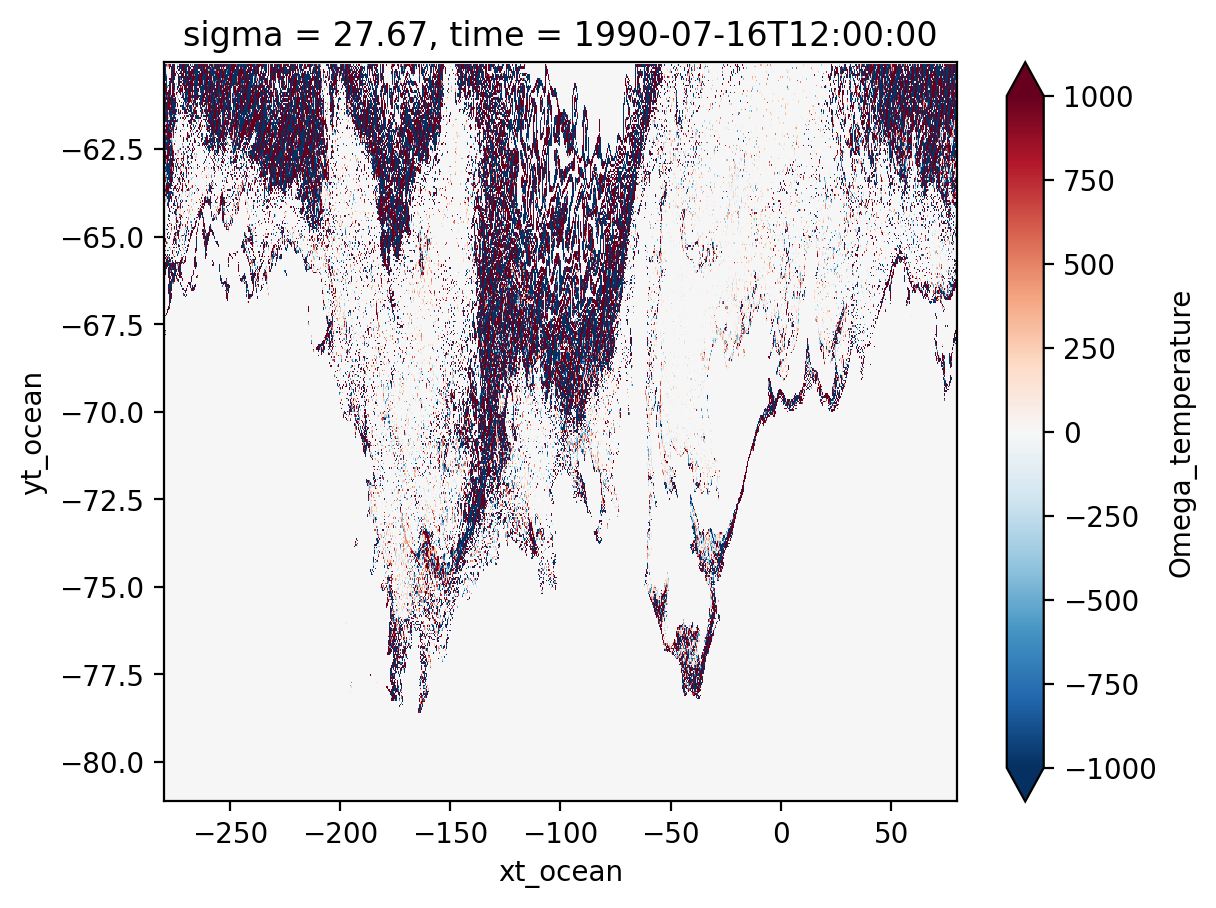

In [100]:
Omega.isel(sigma=0, time=6)["Omega_temperature"].plot(vmin=-1e3, vmax=1e3, cmap="RdBu_r")

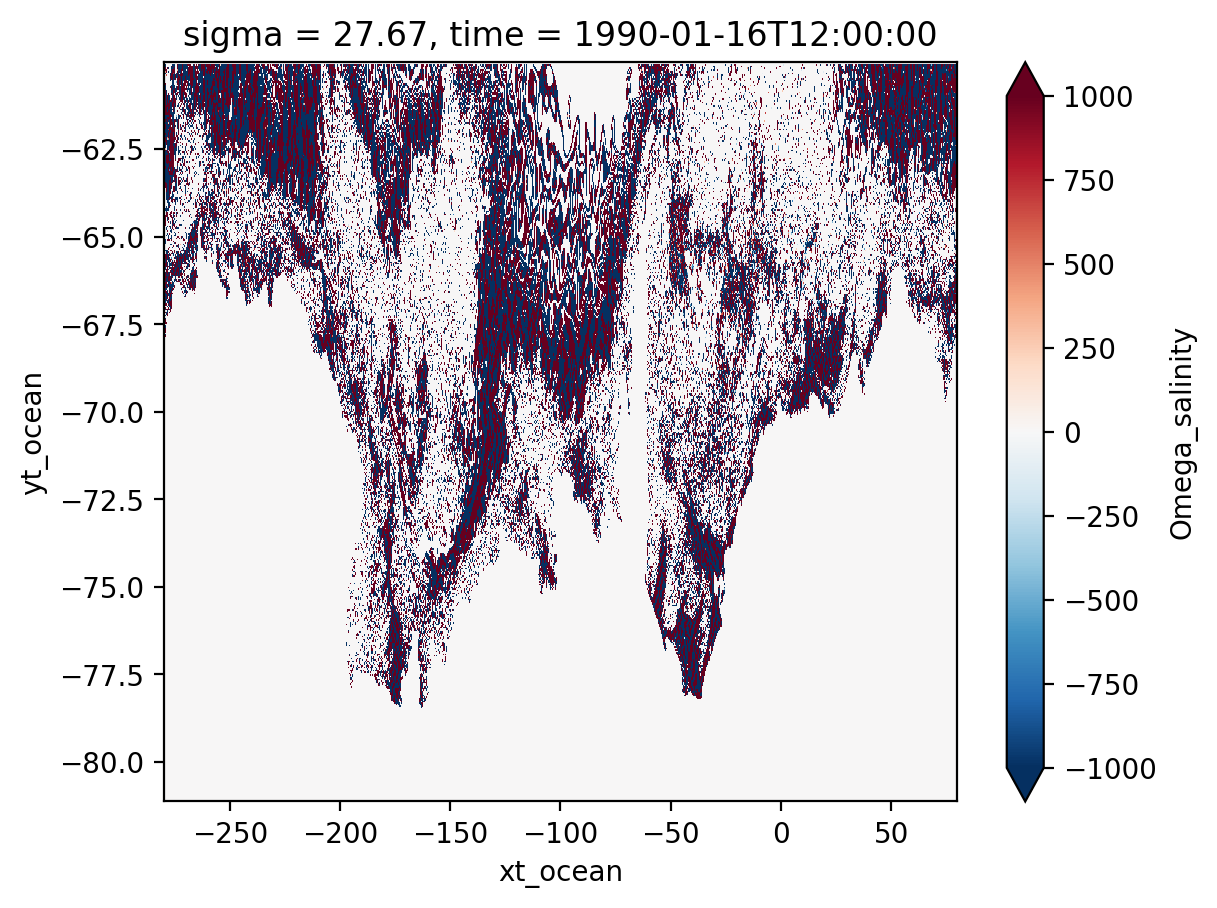

In [111]:
Omega.isel(sigma=0, time=0)["Omega_salinity"].plot(vmin=-1e3, vmax=1e3, cmap="RdBu_r")

In [ ]:
print("start", start, "end", end, "total time", end - start)

In [33]:
y = 1990
DeltaVolume = volume_cell_t.sel(time = slice(str(y)+"-01-01", str(y)+"-04-01"))
Cp, rho0 = 4e3, 1035.0

In [35]:

temp_xdiff = (xgrid.diff(temp_xflux_adv.sel(time=slice(str(y)+"-01-01", str(y)+"-04-01")), "X") / (DeltaVolume.sel(time=slice(str(y)+"-01-01", str(y)+"-04-01")) * Cp*rho0)).load()
temp_ydiff = (xgrid.diff(temp_yflux_adv.sel(time=slice(str(y)+"-01-01", str(y)+"-04-01")), "Y") / (DeltaVolume.sel(time=slice(str(y)+"-01-01", str(y)+"-04-01")) *Cp*rho0)).load()

In [40]:
temp_hdiv = (temp.sel(time=slice(str(y)+"-01-01", str(y)+"-04-01")) - 273.15) *\
            (xgrid.interp(xgrid.derivative(u.sel(time=slice(str(y)+"-01-01", str(y)+"-04-01")), "X"), "Y") +
                                                                      xgrid.interp(xgrid.derivative(v.sel(time=slice(str(y)+"-01-01", str(y)+"-04-01")), "Y"), "X") )

In [115]:
temp_hdiv = temp_hdiv.load()

In [115]:
dsslice.temp.sel(xt_ocean = 0, yt_ocean=-65, method="nearest").differentiate("time", datetime_unit="s").

<xarray.DataArray 'temp' (time: 348, st_ocean: 75)> Size: 104kB
dask.array<_trim, shape=(348, 75), dtype=float32, chunksize=(12, 19), chunktype=numpy.ndarray>
Coordinates:
    xt_ocean  float64 8B 0.05
    yt_ocean  float64 8B -65.02
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 3kB 1990-01-16T12:00:00 ... 2018-12-16T12...

In [116]:
temp.sel(xt_ocean = 0, yt_ocean=-65, method="nearest").shape

(348, 75)

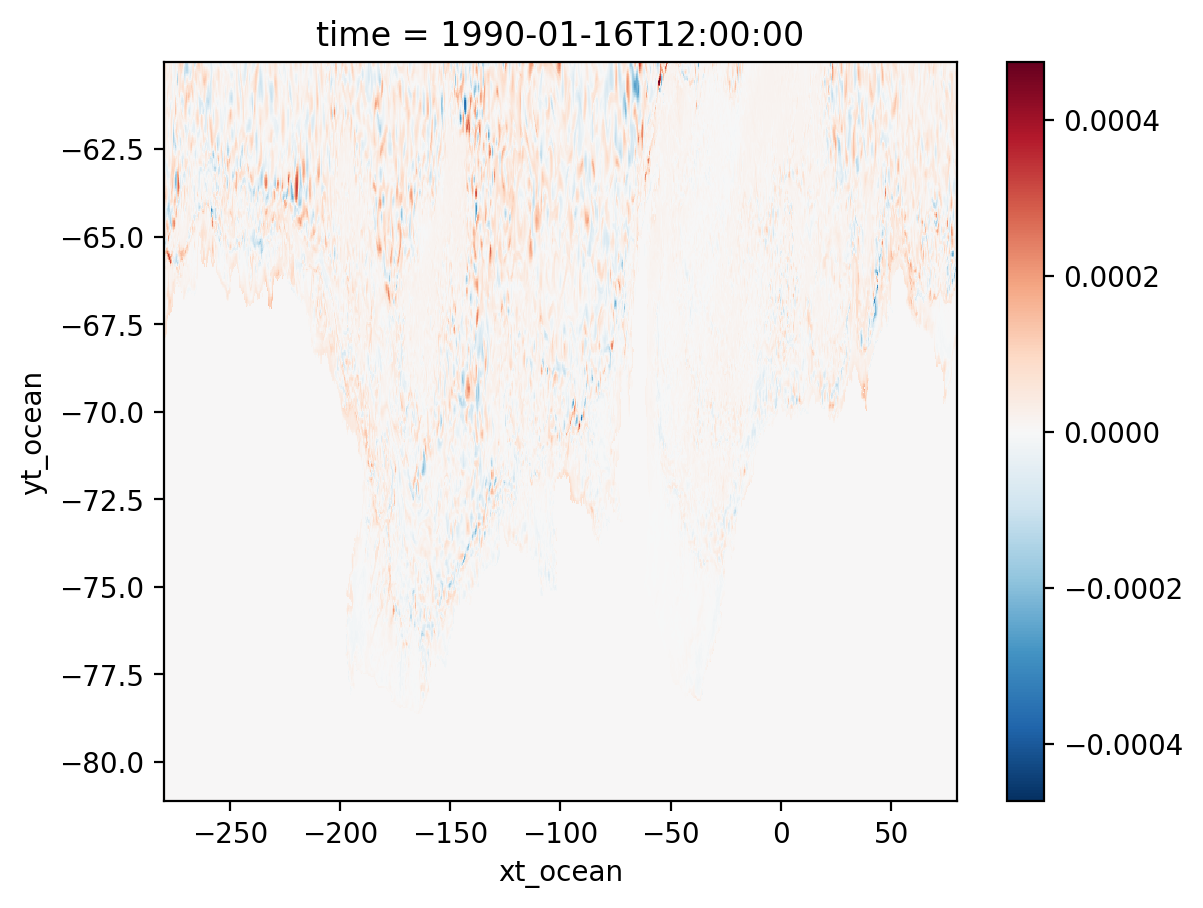

In [112]:
(temp_tend.isel(time=0) * dsslice.dzt.isel(time=0)).sum("st_ocean").plot()

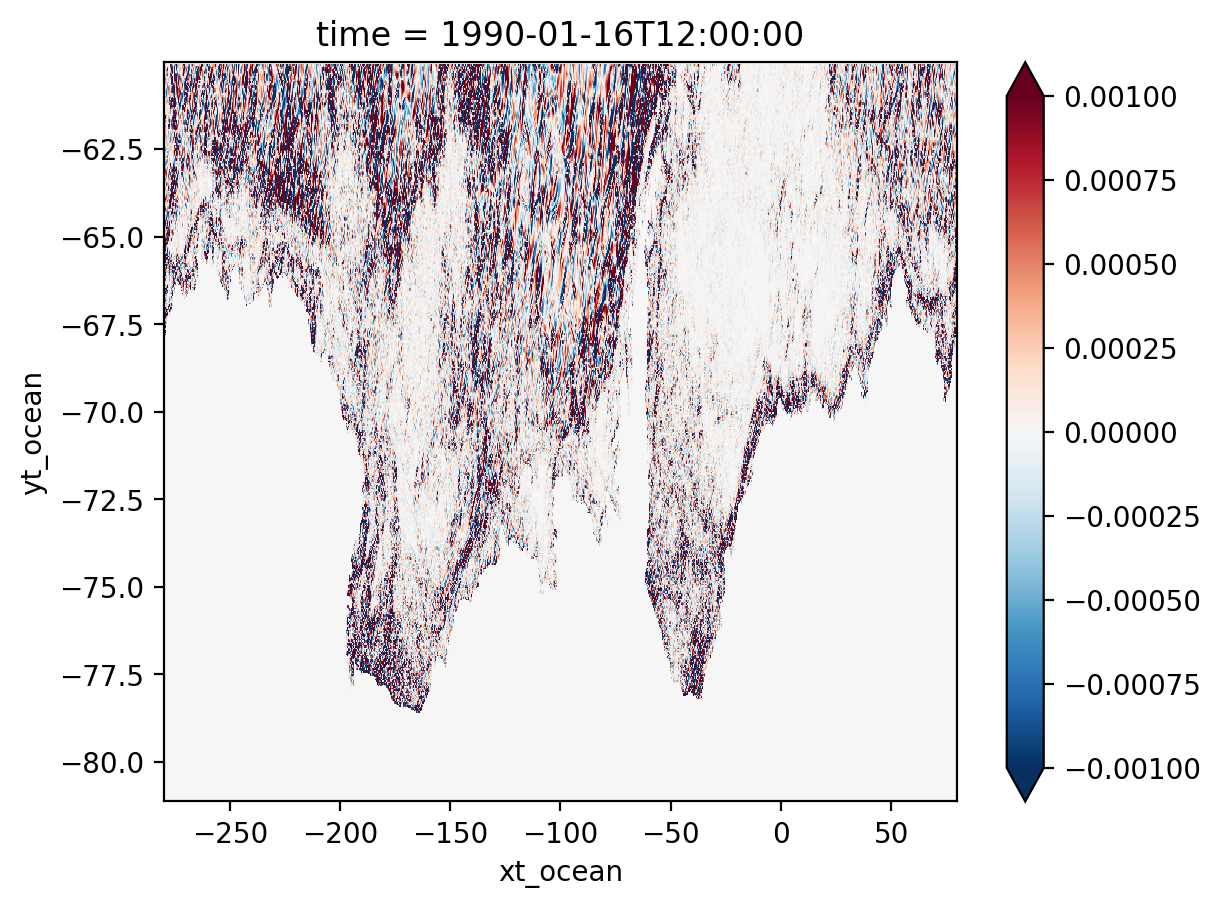

In [113]:
( (temp_xdiff.isel(time=0) + temp_ydiff.isel(time=0) ) * dsslice.dzt.isel(time=0)).sum("st_ocean").plot(cmap="RdBu_r", vmin=-1e-3, vmax=1e-3)

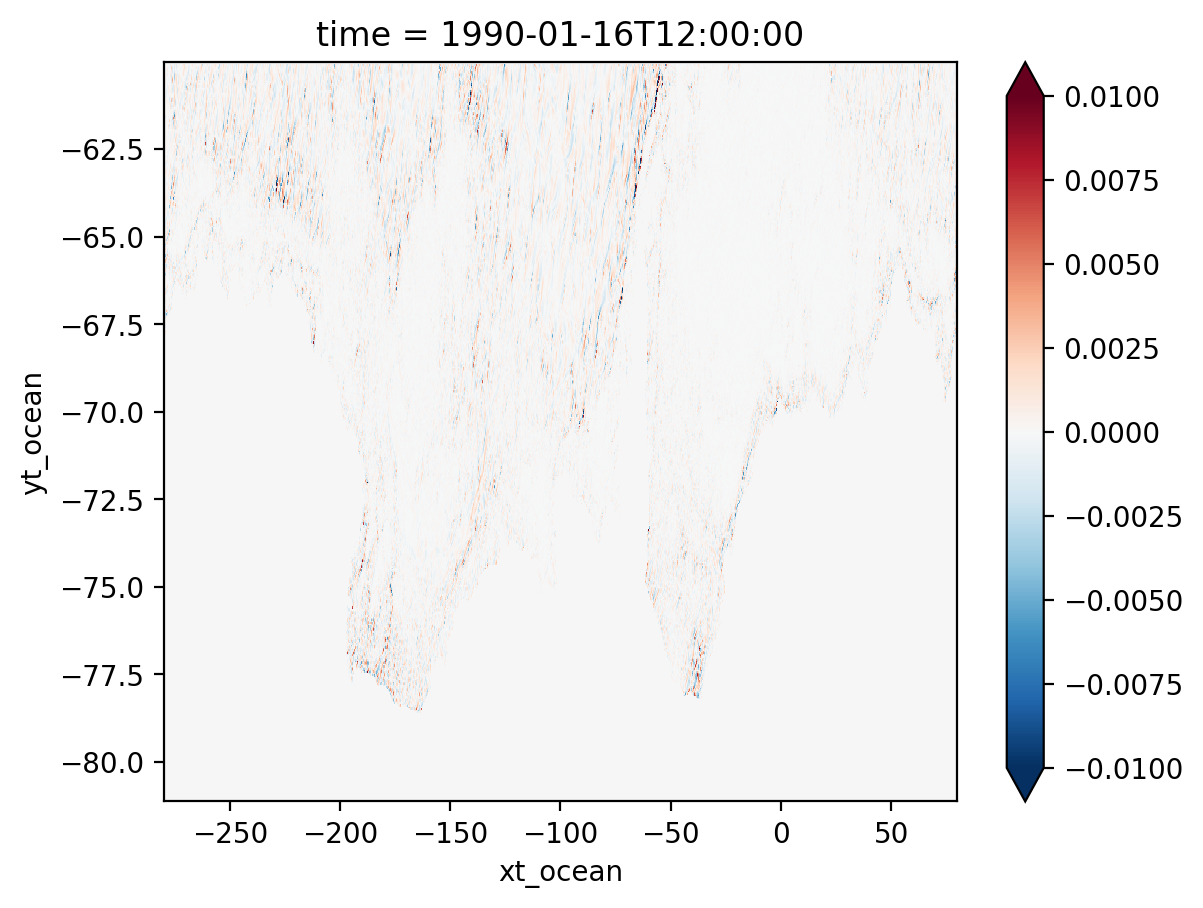

In [114]:
( (temp_xdiff.isel(time=0) + temp_ydiff.isel(time=0) - ((dsslice["temp"]-273.15) * horizontal_divergence).isel(time = 0) ) *\
 dzt.isel(time=0)).sum("st_ocean").plot(cmap="RdBu_r", vmin=-1e-2, vmax=1e-2)

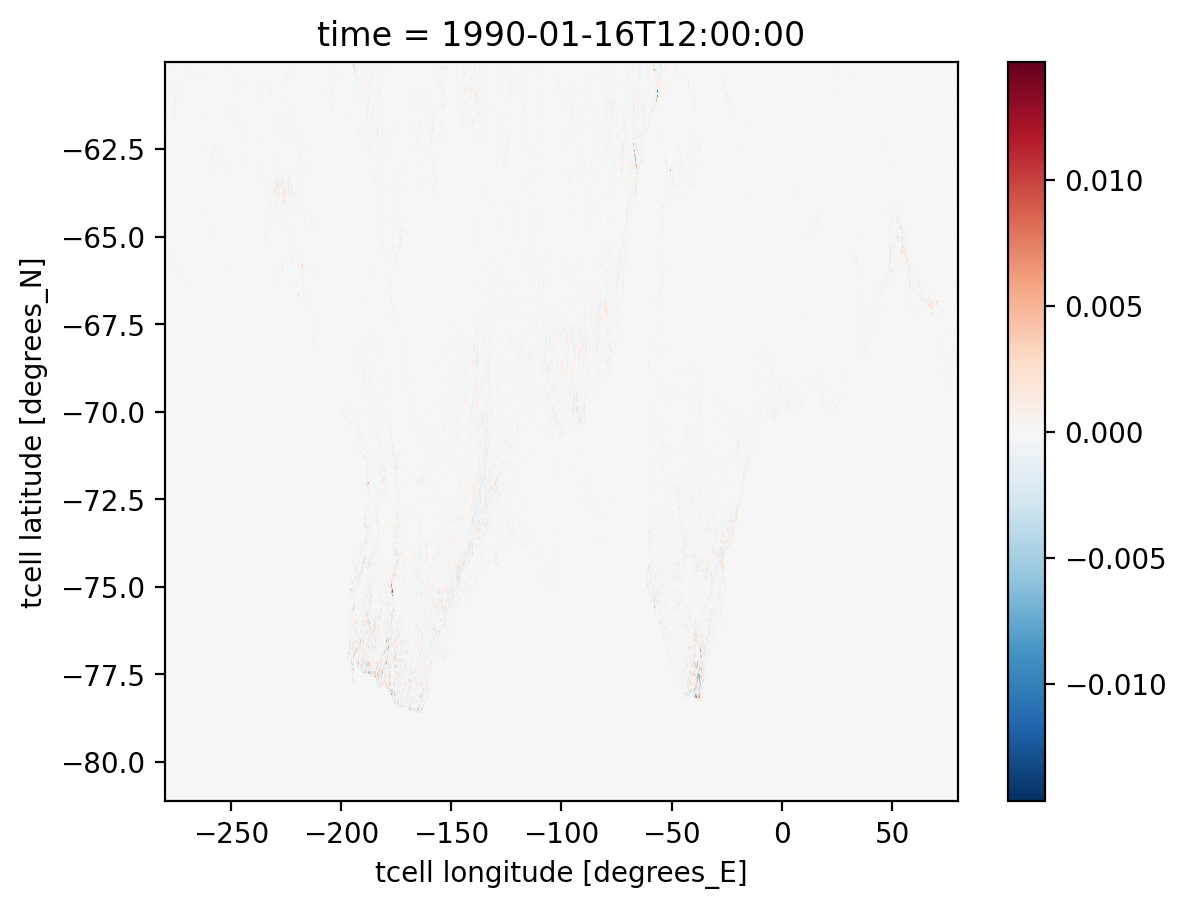

In [42]:
( (temp_hdiv.isel(time = 0) ) * dzt.isel(time=0)).sum("st_ocean").plot(cmap="RdBu_r")

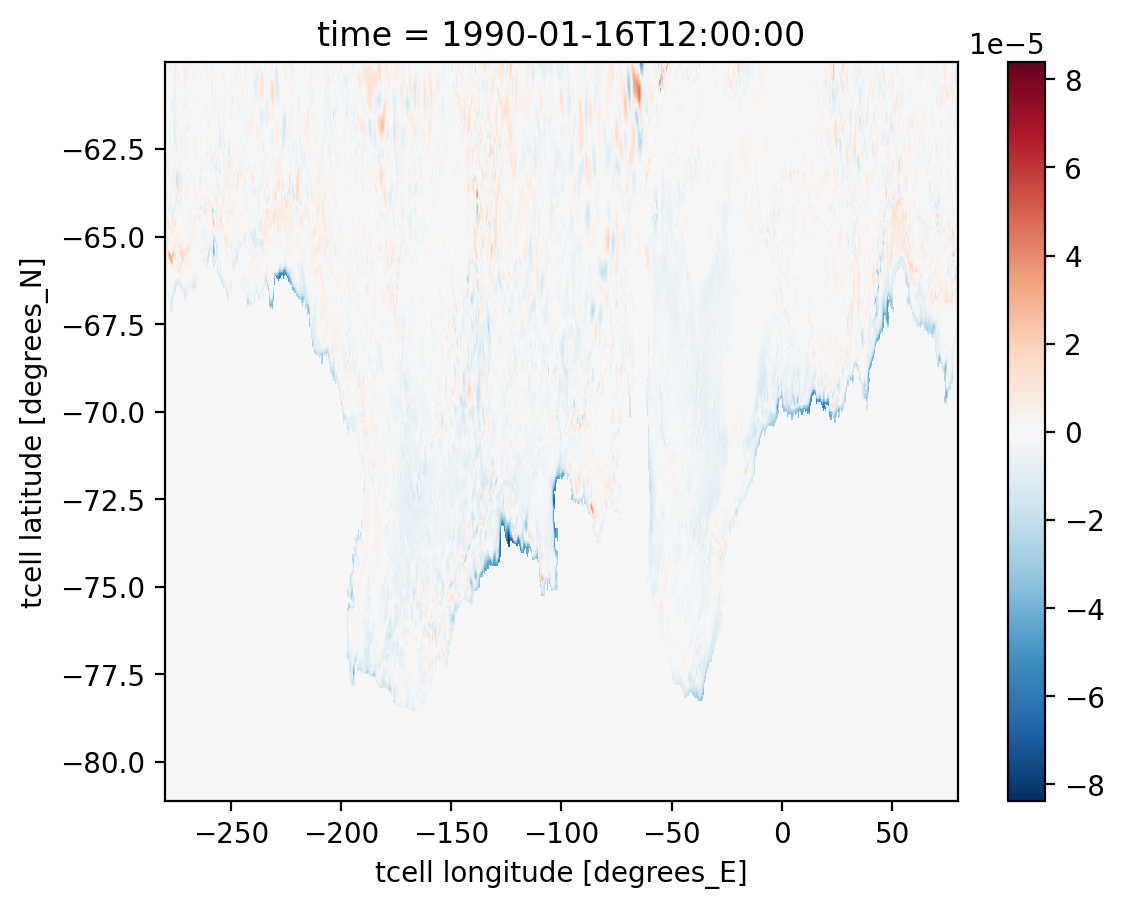

In [90]:
(salt_tend.isel(time=0) * dzt.isel(time=0)).sum("st_ocean").plot()

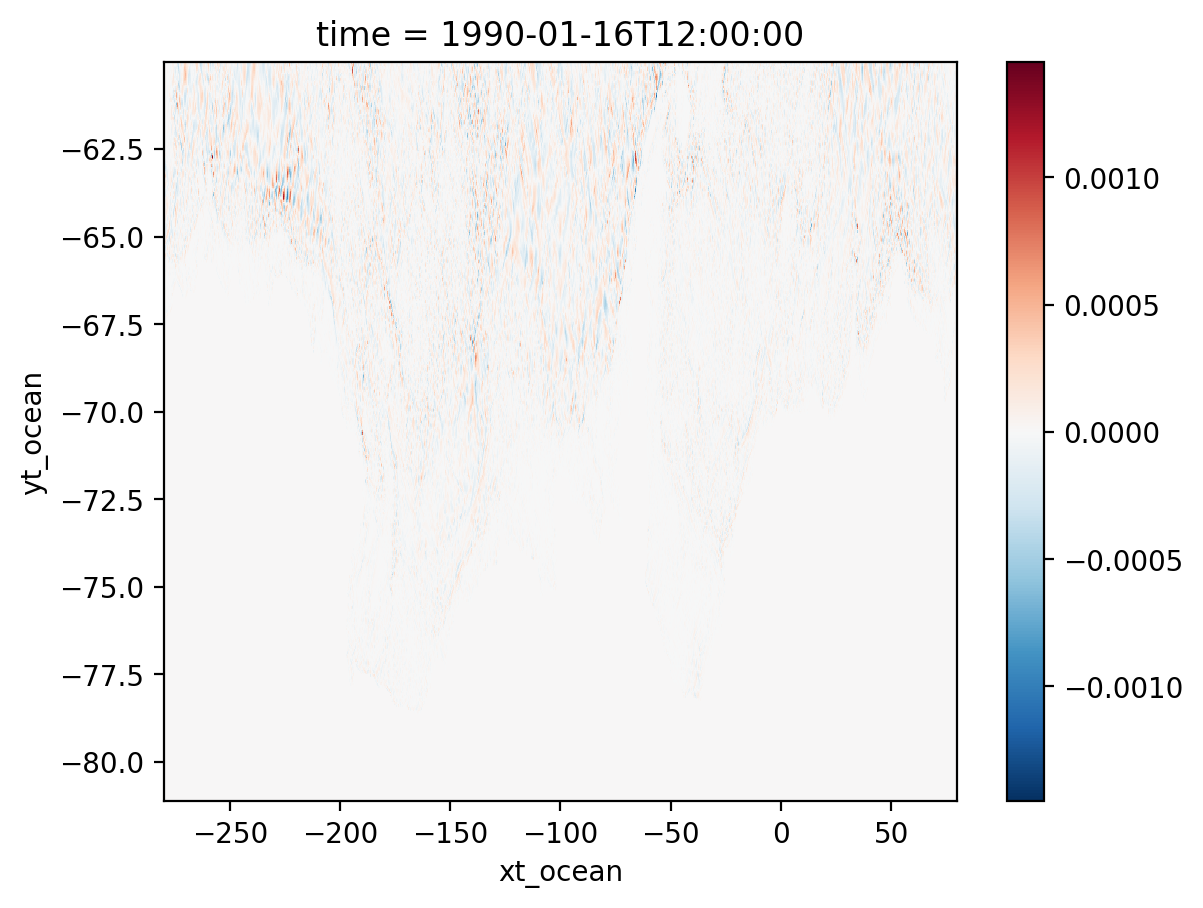

In [91]:
(salt_xdiff.isel(time=0) * dzt.isel(time=0)).sum("st_ocean").plot()

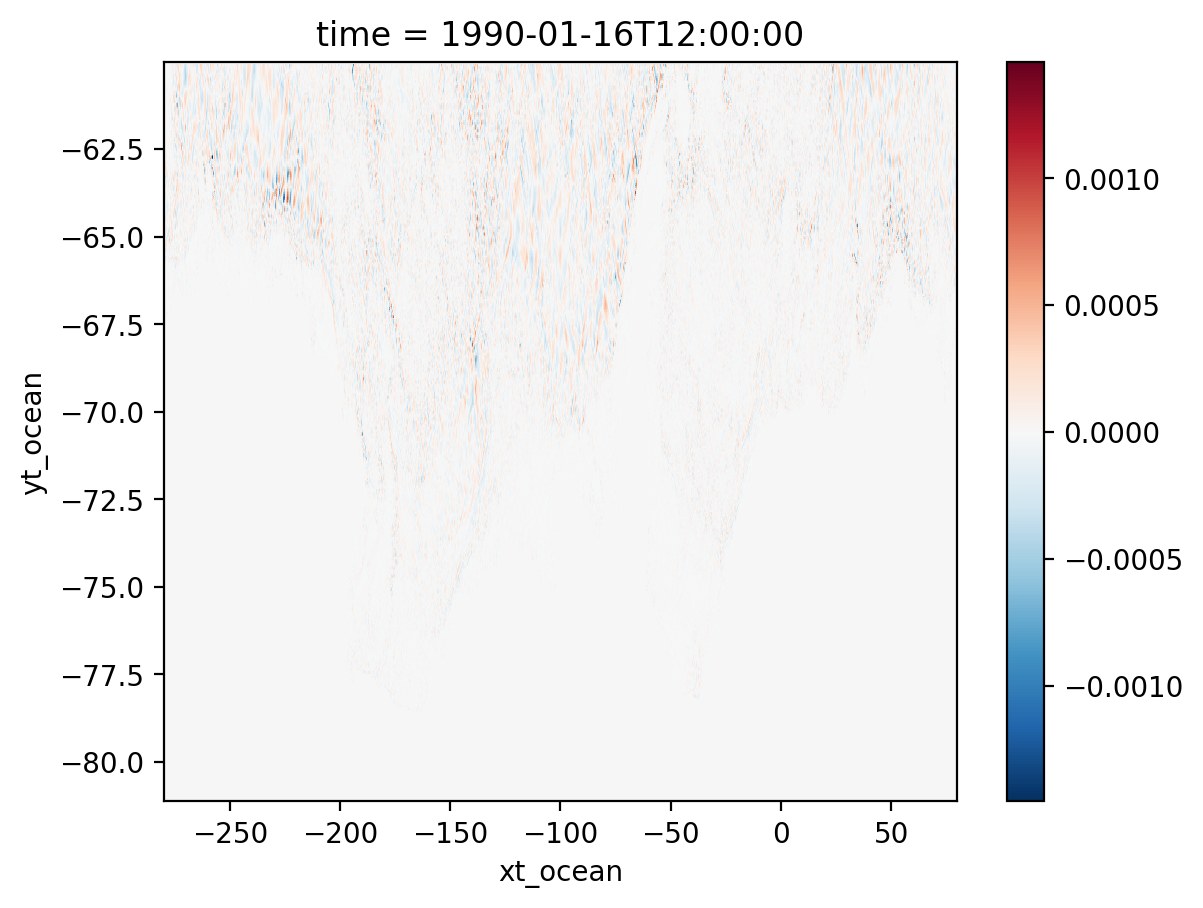

In [92]:
(salt_ydiff.isel(time=0) * dzt.isel(time=0)).sum("st_ocean").plot()

In [ ]:
end = time.time()

In [ ]:
print("time elapsed", (end - start)/3600)

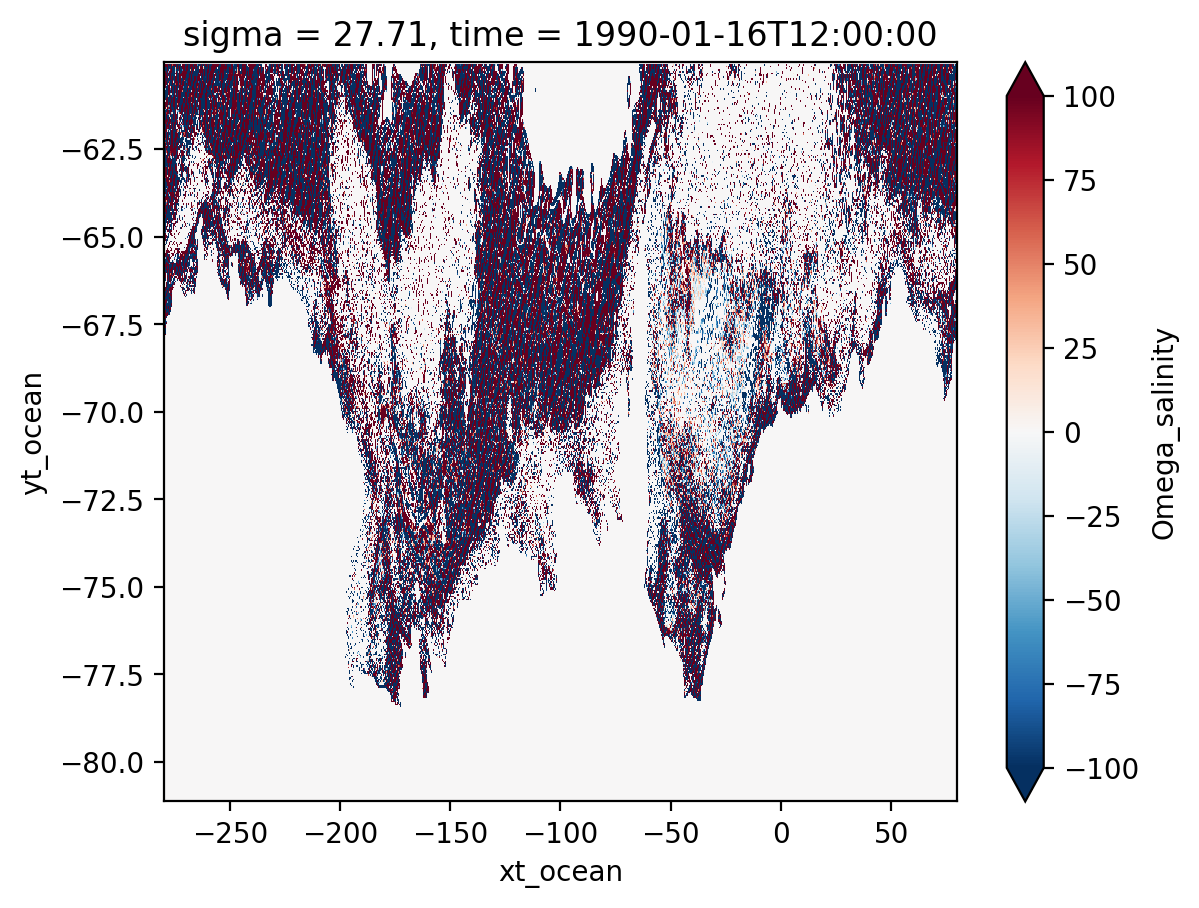

In [87]:
Omega["Omega_salinity"].isel(time=0, sigma=3).plot(vmin=-1e2, vmax=1e2, cmap="RdBu_r")

In [107]:
Omega["Omega_salinity"].isel(time=4, sigma=3).sum()/1e6

<xarray.DataArray 'Omega_salinity' ()>
array(-1.91055713)
Coordinates:
    sigma    float64 27.71
    time     datetime64[ns] 1990-05-16T12:00:00

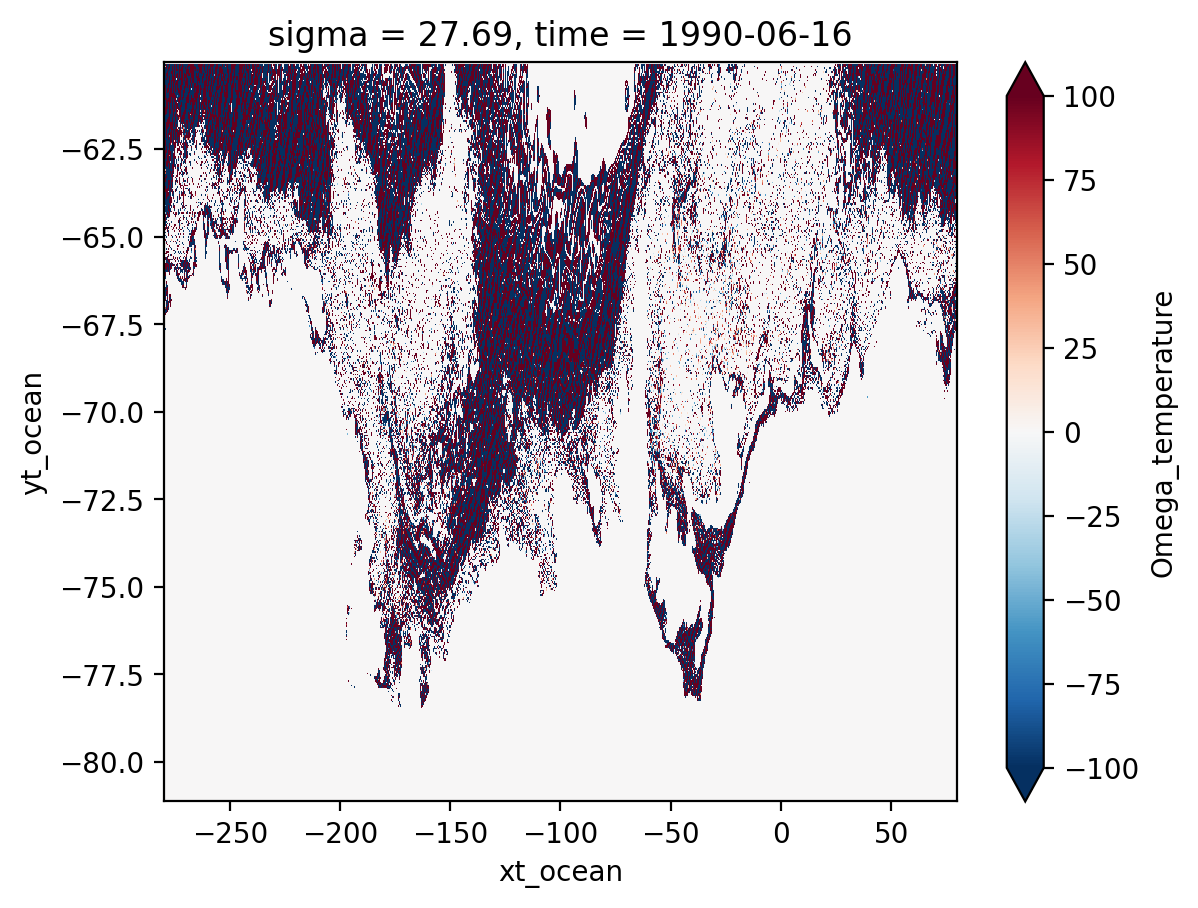

In [110]:
Omega["Omega_temperature"].isel(time=5, sigma=2).plot(vmin=-1e2, vmax=1e2, cmap="RdBu_r")

In [112]:
Omega["Omega_temperature"].isel(time=5, sigma=2).sum()/1e6

<xarray.DataArray 'Omega_temperature' ()>
array(58.15324356)
Coordinates:
    sigma    float64 27.69
    time     datetime64[ns] 1990-06-16

In [34]:
348 * 19 * 400 * 3600

9521280000

In [ ]:
(len(temp.time.values), len(sigma_intervals)-1, len(temp.yt_ocean.values), len(temp.xt_ocean.values) )

In [ ]:

for si in range(len(sigma_intervals)-1):
    sigma_seld = pot_rho_0.sel(time =slice(ts,te))
    Omega[si] =  (tarea * (Dsigma_Dt.\
                    where((sigma_seld < (sigma_intervals[si] + sigma_delta*0.5)) & 
                          (sigma_seld > (sigma_intervals[si] - sigma_delta*0.5)) ) * 
                                                ds["delta_s_w2w"]).sel(st_ocean=slice(0,1000)).sum("st_ocean") /\
                                  sigma_delta).fillna(0.0) #fillna to avoid propagating NaNs; 0 to 700m because potential density approximates a neutral surface within ~500m of it's reference surface. Also, we are looking at near-surface processes here.

# Experimental and trial work below

In [ ]:
for y in years_to_step_by:
    print(y)

    # create an Omega for each year (~2.5GB). Omega is the WMT
    Omega = np.full_like(np.zeros((2, len(sigma_intervals)-1, 12, len(temp.yt_ocean.values), len(temp.xt_ocean.values) )), fill_value=0.)
    # Create an array, Omega, to store the transformation rates. We will store the temperature and salinity component separately.
    
    Cp, rho0 = 4e3, 1035.0

    Dtemp_Dt = temp.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")).differentiate("time", datetime_unit="s") + xgrid.diff(temp_xflux_adv.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")), "X") / (volume_cell_t*Cp*rho0) + \
               xgrid.diff(temp_yflux_adv.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")), "Y") / (volume_cell_t*Cp*rho0)

    Dsalt_Dt = salt.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")).chunk((12, 19, 135, 180)).differentiate("time", datetime_unit="s") + xgrid.diff(salt_xflux_adv.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")), "X") / (rho0*volume_cell_t) + \
               xgrid.diff(salt_yflux_adv.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")), "Y") / (rho0*volume_cell_t)

    DsaltAbs_Dt = gsw.SA_from_SP(Dsalt_Dt, st_ocean, Dsalt_Dt.xt_ocean, Dsalt_Dt.yt_ocean)

    absSalt = gsw.SA_from_SP(salt, st_ocean, salt.xt_ocean, salt.yt_ocean)

    alpha = gsw.alpha(absSalt, temp, st_ocean)

    beta = gsw.beta(absSalt, temp, st_ocean)

    Dsigma_Dt_temp = -rho0 * alpha * Dtemp_Dt

    Dsigma_Dt_salt = rho0 * beta * DsaltAbs_Dt

    Dsigma_Dt = Dsigma_Dt_temp + Dsigma_Dt_salt
    
    sigma_seld = pot_rho_0.sel(time = slice(str(y)+"-01-01", str(y)+"-05-01")).sel(st_ocean=slice(0,1000))
    
    for si in range(len(sigma_intervals)-1):
        Omega[0, si] =  (tarea * (Dsigma_Dt_temp.sel(st_ocean=slice(0,1000)).\
                                  where((sigma_seld < (sigma_intervals[si] + sigma_delta*0.5)) & 
                                          (sigma_seld > (sigma_intervals[si] - sigma_delta*0.5)) ) * 
                                                dzt.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")).sel(st_ocean=slice(0,1000))).sum("st_ocean") /\
                                                  sigma_delta).fillna(0.0).transpose("time", "yt_ocean", "xt_ocean") 
        #fillna to avoid propagating NaNs; 0 to 700m because potential density approximates a neutral surface within ~500m of it's reference surface. Also, we are looking at near-surface processes here.

        Omega[1, si] =  (tarea * (Dsigma_Dt_salt.sel(st_ocean=slice(0,1000)).\
                                  where((sigma_seld < (sigma_intervals[si] + sigma_delta*0.5)) & 
                                          (sigma_seld > (sigma_intervals[si] - sigma_delta*0.5)) ) * 
                                                dzt.sel(time=slice(str(y)+"-01-01", str(y)+"-05-01")).sel(st_ocean=slice(0,1000))).sum("st_ocean") /\
                                                  sigma_delta).fillna(0.0).transpose("time", "yt_ocean", "xt_ocean") 
        #fillna to avoid propagating NaNs; 0 to 700m because potential density approximates a neutral surface within ~500m of it's reference surface. Also, we are looking at near-surface processes here.

1990


In [ ]:
Omega = xr.Dataset({"Omega_temperature":Omega[0],
                    "Omega_salinity":Omega[1]}, 
                    coords = {"sigma":(["sigma"], sigma_intervals[-1]),
                              "time":(["time"], Dsigma_Dt.time),
                             "yt_ocean":(["yt_ocean"], Dsigma_Dt.yt_ocean)})

In [7]:
x = np.arange(0, 51, 5)
delta_x = np.diff(x)
y = np.linspace(0, 10, x.shape[-1])
delta_y = np.diff(y)

u = np.random.randn(delta_x.shape[-1])
theta = np.random.randn(delta_x.shape[-1]) + 10

In [10]:
np.diff(u*theta*delta_y) / (delta_x*delta_y)[:-1]

array([-4.48262572, -1.4165097 ,  4.2525832 , -2.62312913, -3.42340953,
        2.75148562, -2.05581626, -2.02625185,  6.77570832])

In [11]:
np.diff(u*theta)/delta_x[:-1]

array([-4.48262572, -1.4165097 ,  4.2525832 , -2.62312913, -3.42340953,
        2.75148562, -2.05581626, -2.02625185,  6.77570832])